In [1]:
from keras.layers import Input, Flatten,MaxPooling2D, Dense, Conv2D, Conv2DTranspose, Reshape, Lambda, LeakyReLU, BatchNormalization, Activation, Concatenate
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.losses import mse, binary_crossentropy
import keras.backend as K
from tqdm.autonotebook import trange
import os
import cv2
import numpy as np
import tensorflow as tf
import keras 

Using TensorFlow backend.
/Users/Dima/anaconda3/envs/DataScience/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [8]:
def get_generator():
    inputs = Input((218,178,1))
    x = Conv2D(64,3,strides=1,activation='relu', padding='same')(inputs)
    x = Conv2D(64,3,strides=1,activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2))(x)
  
    x = Conv2D(64,3,strides=1,activation='relu', padding='same')(x)
    x = Conv2D(64,3,strides=1,activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  
    x = Conv2D(64,3,strides=1,activation='relu', padding='same')(x)
    x = Conv2D(64,3,strides=1,activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  
    #Trasnspose block
    x = Conv2DTranspose(64,2,strides=2,activation='relu')(x)
    x = Conv2DTranspose(32,3,strides=2,activation='relu')(x)
    outputs = Conv2DTranspose(3,2,strides=2)(x)
    return Model(inputs=inputs,outputs=outputs)

In [9]:
def get_discriminator():
    """ Builds the discriminator network which tries to discriminate real images from fakes. """
    # Input is a 64x64 image
    inputs = Input((218,178,3))
  
    # Strided convolutions to downsample
    x = Conv2D(32,4,strides=2,activation=None,padding='same')(inputs) 
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
  
    x = Conv2D(64,4,strides=2,activation=None,padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
  
    x = Conv2D(128,4,strides=2,activation=None,padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
  
    x = Conv2D(64,4,strides=2,activation=None,padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
  
    x = Conv2D(32,4,strides=2,activation=None,padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Final output with sigmoid activation for binary classification
    x = Flatten()(x)
    outputs = Dense(1,activation='sigmoid')(x)
  
    return Model(inputs=inputs,outputs=outputs)

In [10]:
def setup_gan_training(generator,discriminator):
  g_opt = Adam(lr=0.0002,beta_1=0.5,beta_2=0.999,epsilon=1e-3)
  d_opt = Adam(lr=0.0002,beta_1=0.5,beta_2=0.999,epsilon=1e-3)

  generator.compile(loss='binary_crossentropy',optimizer=g_opt)
  discriminator.compile(loss='binary_crossentropy',optimizer=d_opt)

  discriminator.trainable = False
  inputs = Input((218,178,1))
  x = generator(inputs)
  outputs = discriminator(x)
  
  d_on_g = Model(inputs=inputs,outputs=outputs)
  d_on_g.compile(loss='binary_crossentropy',optimizer=g_opt)
  
  return d_on_g

In [11]:
def sample_from_generator(generator, edges):
  v = np.random.choice(edges.shape[0], 32)
  noise_input = edges[v]
  x_fake = np.squeeze(generator.predict(noise_input))
  n = 0
  for i in range(4):
    for j in range(8):
      plt.subplot(4,8,n+1)
      plt.imshow(x_fake[n].astype(np.uint8))
      plt.axis('off')
      n = n+1
  plt.show()

In [12]:
def train_gan(generator, discriminator, d_on_g,
              x, images, num_epochs=100, batch_size=64):
  num_batches = len(x) // batch_size
    
  gen_loss_history = []
  discrim_loss_history = []
    
  for i in range(num_epochs):
    inds = np.arange(len(x))
    np.random.shuffle(inds)
        
    for j in trange(num_batches):
      noise_input = np.random.normal(size=(batch_size, 218,178,1))
            
      x_real = images[inds[(j*batch_size):((j+1)*batch_size)]]
      y_real = [1]*batch_size

      x_fake = generator.predict(noise_input, batch_size=batch_size)
      y_fake = [0]*batch_size

      discriminator.trainable = True
      real_loss = discriminator.train_on_batch(x_real, y_real)
      fake_loss = discriminator.train_on_batch(x_fake, y_fake)
      discrim_loss = 0.5*(real_loss + fake_loss)
      
      x_generator = x[inds[(j*batch_size):((j+1)*batch_size)]]
      y_generator = [1]*batch_size
      discriminator.trainable = False
      gen_loss = d_on_g.train_on_batch(x_generator, y_generator)

      gen_loss_history.append(gen_loss)
      discrim_loss_history.append(discrim_loss)
    print('epoch %d: discriminator loss: %.2f\tgenerator loss: %.2f'%(i+1,discrim_loss,gen_loss))
    sample_from_generator(generator, x)
    
  return gen_loss_history, discrim_loss_history

In [13]:
generator = get_generator()
discriminator = get_discriminator()
d_on_g = setup_gan_training(generator,discriminator)

print(generator.summary())
print(discriminator.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 218, 178, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 218, 178, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 178, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 89, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 89, 64)       36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 89, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 44, 64)        0         
__________

/Users/Dima/anaconda3/envs/DataScience/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [14]:
def create_image_data(root):
    images = []
    for subdir, dirs, files in os.walk(root):
        for i, file in enumerate(files):
            read_file = subdir + "/" + file
            img = cv2.imread(read_file)
            if ('ipynb' not in read_file and 'DS' not in read_file):
                images.append(img)
                if i % 10000 == 9999:
                    print(str(i) + " Daddy")
                    break
    return np.array(images)

In [15]:
im_dat = create_image_data('../train_data/')

9999 Daddy


In [16]:
im_dat.shape

(10000, 218, 178, 3)

In [17]:
def getCanny(image):
    #nmp = np.transpose(image, (1, 2, 0))
    nmp = np.uint8(image)
    nmp = cv2.Canny(nmp, 218, 178)
    return nmp

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
mvals = np.array([getCanny(x) for x in im_dat[:100]])

In [20]:
x = mvals.reshape([-1, 218, 178, 1])


epoch 1: discriminator loss: 0.34	generator loss: 0.69


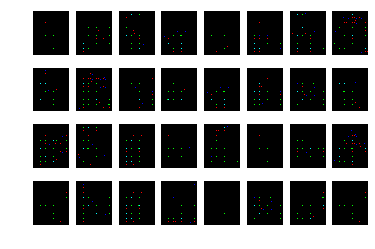


epoch 2: discriminator loss: 0.31	generator loss: 0.70


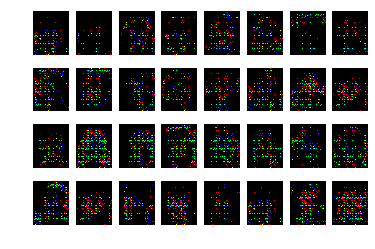


epoch 3: discriminator loss: 0.21	generator loss: 0.35


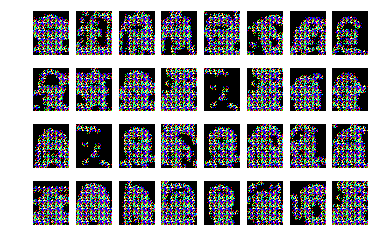


epoch 4: discriminator loss: 0.03	generator loss: 0.30


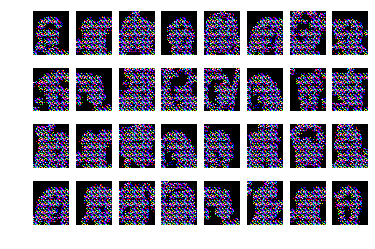


epoch 5: discriminator loss: 0.29	generator loss: 0.06


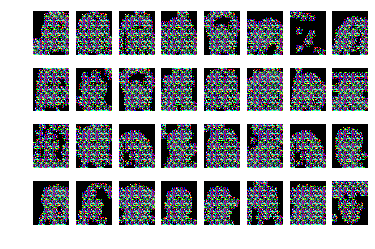


epoch 6: discriminator loss: 0.03	generator loss: 0.02


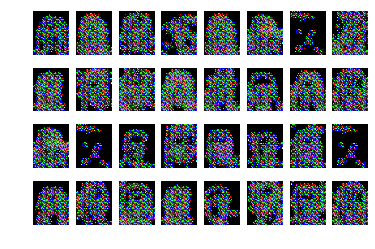


epoch 7: discriminator loss: 0.01	generator loss: 0.00


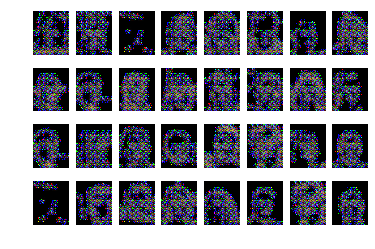


epoch 8: discriminator loss: 0.00	generator loss: 0.05


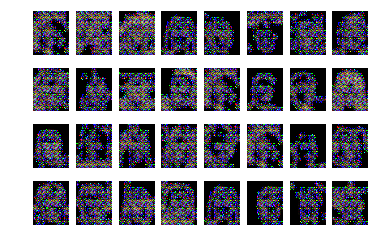


epoch 9: discriminator loss: 0.00	generator loss: 0.00


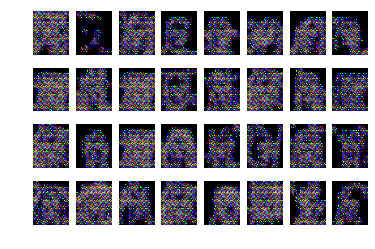


epoch 10: discriminator loss: 0.00	generator loss: 0.04


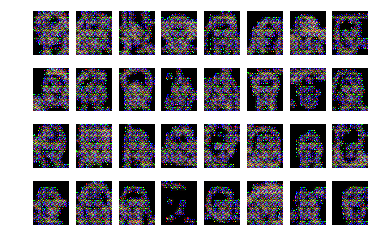

([0.6979735,
  0.69253314,
  0.69723845,
  0.692127,
  0.690561,
  0.6937171,
  0.69560194,
  0.6911117,
  0.69361514,
  0.69465834,
  0.69177294,
  0.6948195,
  0.69403267,
  0.69870156,
  0.6925498,
  0.69344133,
  0.69259936,
  0.6941784,
  0.6968118,
  0.6909462,
  0.6938344,
  0.68884677,
  0.6974122,
  0.6947983,
  0.7000221,
  0.69436157,
  0.69554985,
  0.698887,
  0.6952293,
  0.6995058,
  0.70080036,
  0.6902407,
  0.6952176,
  0.7045064,
  0.70302594,
  0.69947195,
  0.7079364,
  0.70112324,
  0.6889631,
  0.7004343,
  0.6803693,
  0.7011785,
  0.671829,
  0.68590933,
  0.6779405,
  0.67507064,
  0.63755894,
  0.64815325,
  0.63941485,
  0.5767188,
  0.6305048,
  0.51567256,
  0.49766523,
  0.503572,
  0.46493596,
  0.44340628,
  0.34934822,
  0.2650904,
  0.3072878,
  0.34600216,
  0.24311543,
  0.54460156,
  0.33769226,
  0.552777,
  1.6444473,
  0.44906345,
  0.5211769,
  2.4969053,
  2.9454336,
  2.4216263,
  1.3863213,
  1.4269335,
  0.38802788,
  0.3375,
  0.4089169,
 

In [21]:
train_gan(generator, discriminator, d_on_g, x, im_dat[:100], num_epochs=10, batch_size=5)

In [78]:
x.shape

(100, 218, 178, 1)

In [82]:
v = np.random.choice(x.shape[0], 5)

In [84]:
x[v].shape

(5, 218, 178, 1)

In [20]:
mvals = np.array([getCanny(x) for x in im_dat[100:200]])

x = mvals.reshape([-1, 218, 178, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

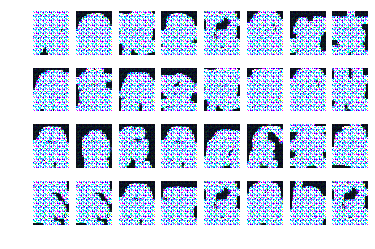

In [19]:
sample_from_generator(generator, x)

In [18]:
from keras.utils import multi_gpu_model

In [24]:
parallel_model = multi_gpu_model(generator, gpus=5)

ValueError: To call `multi_gpu_model` with `gpus=5`, we expect the following devices to be available: ['/cpu:0', '/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3', '/gpu:4']. However this machine only has: ['/cpu:0']. Try reducing `gpus`.